**Object Detection with Resnet 50 as Backbone**

##### Note: We ran the notebook on a very small dataset to check the notebook working fine so the graph and output maybe bad, dataset percentage can be set by changing "subset_percentage" variable in the code.

1. Installing the pycocotools library, which is used for handling COCO dataset annotations and Importing Required Libraries

In [1]:
!pip install pycocotools

import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader, Subset
from torchvision import transforms

import matplotlib.pyplot as plt
import os
import random

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 21.2 MB/s eta 0:00:00


2. Creating an output directory and a list which contains the names of the 80 object categories in the COCO dataset.

In [2]:
os.makedirs("output", exist_ok=True)

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
    'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant',
    'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle',
    'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
    'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet',
    'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator',
    'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

3. Preparing the COCO dataset for training and validation.

   - Resize all images to 640x640 pixels.
   - Convert images to PyTorch tensors.
  
   - Specify the paths to training images, validation images and annotations in kaggle environment. (coco dataset has to be downloaded first)
  
   - Randomly select 10% of the training and validation images for faster experimentation or testing.

In [3]:
transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor()
])


print("Loading datasets...")
train_root = '/kaggle/input/coco-2017-dataset/coco2017/train2017'
val_root = '/kaggle/input/coco-2017-dataset/coco2017/val2017'
annotations_path = '/kaggle/input/coco-2017-dataset/coco2017/annotations'


train_dataset_full = CocoDetection(
    root=train_root,
    annFile=f'{annotations_path}/instances_train2017.json',
    transform=transform
)

val_dataset_full = CocoDetection(
    root=val_root,
    annFile=f'{annotations_path}/instances_val2017.json',
    transform=transform
)


subset_percentage = 0.5
random.seed(42)
train_indices = random.sample(range(len(train_dataset_full)), int(len(train_dataset_full) * subset_percentage))
val_indices = random.sample(range(len(val_dataset_full)), int(len(val_dataset_full) * subset_percentage))

train_dataset = Subset(train_dataset_full, train_indices)
val_dataset = Subset(val_dataset_full, val_indices)

print(f"Training dataset size: {len(train_dataset)}, Validation dataset size: {len(val_dataset)}")

Loading datasets...
loading annotations into memory...
Done (t=18.97s)
creating index...
index created!
loading annotations into memory...
Done (t=2.26s)
creating index...
index created!
Training dataset size: 59, Validation dataset size: 2


4. Both images and their corresponding annotations (targets) are processed and prepared for training.

   - COCO annotations provide bounding boxes in [x_min, y_min, width, height] format which we are converting to [x_min, y_min, x_max, y_max] format.
   - Extracting category_id (class labels) for each object from annotations.
   - Making a dictionary for bounding boxes and labels (class categories).
   - Collate function prepares a batch of images and targets for training.

In [4]:
def preprocess_targets(raw_targets):
    processed_targets = []
    for target in raw_targets:
        if len(target) == 0:
            continue

        boxes = torch.tensor([t["bbox"] for t in target], dtype=torch.float32)
        boxes[:, 2] += boxes[:, 0]
        boxes[:, 3] += boxes[:, 1]
        labels = torch.tensor([t["category_id"] for t in target], dtype=torch.int64)
        processed_targets.append({"boxes": boxes, "labels": labels})
    return processed_targets

def collate_fn(batch):
    images, raw_targets = zip(*batch)
    processed_targets = preprocess_targets(raw_targets)
    valid_batch = [(img, tgt) for img, tgt in zip(images, processed_targets) if "boxes" in tgt and len(tgt["boxes"]) > 0]
    if len(valid_batch) == 0:
        return [], []
    images, targets = zip(*valid_batch)
    return list(images), list(targets)

5. Model definition for Object Detection.
   - It is using a pre-trained ResNet-50 as the backbone.
   - Removed the final fully connected (FC) layers, keeping only the convolutional layers. This allows the model to extract high-level spatial features from the input image.
   - A fully connected layer to reduce dimensions.
   - A ReLU activation function to add non-linearity.
   - A dropout layer to prevent overfitting.
   - Another fully connected layer to output logits for all num_classes for each bounding box.

6. Regression Head:
   - Predicts bounding box coordinates ([x_min, y_min, x_max, y_max]) for each detected object.
   - Its structure is similar to the classification head but outputs 4 values per bounding box.

7. Forward Method:
   - Passes the input batch of images through the backbone to extract features.
   - Pooling to reduce the spatial dimensions of the features to a fixed size of (7, 7) for compatibility with the classification and regression heads.
   - Passing the pooled features through the classification and regression heads.
   - class_logits: Classification scores for all bounding boxes.
   - bbox_regressions: Predicted coordinates for all bounding boxes.
   - Initializing weights of the classification and regression heads to ensure better learning during training.

In [5]:
class CustomObjectDetectionModel(nn.Module):
    def __init__(self, num_classes, num_boxes_per_image):
        super(CustomObjectDetectionModel, self).__init__()
        self.num_boxes_per_image = num_boxes_per_image
        self.backbone = torchvision.models.resnet50(weights="DEFAULT")
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])
        self.classification_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048 * 7 * 7, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, num_boxes_per_image * num_classes)
        )
        self.regression_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048 * 7 * 7, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, num_boxes_per_image * 4)
        )
        self._init_weights()

    def forward(self, x):
        features = self.backbone(x)
        pooled_features = nn.AdaptiveAvgPool2d((7, 7))(features)
        class_logits = self.classification_head(pooled_features)
        bbox_regressions = self.regression_head(pooled_features)
        batch_size = x.shape[0]
        class_logits = class_logits.view(batch_size, self.num_boxes_per_image, -1)
        bbox_regressions = bbox_regressions.view(batch_size, self.num_boxes_per_image, 4)
        return class_logits, bbox_regressions

    def _init_weights(self):
        for layer in self.classification_head:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                nn.init.constant_(layer.bias, 0)
        for layer in self.regression_head:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                nn.init.constant_(layer.bias, 0)

8. Settings:
- Selects GPU if available, otherwise uses CPU.
- num_classes: Number of object classes.
- num_boxes_per_image: The model is designed to predict a fixed number of bounding boxes per image (10).
- Initializes the custom object detection model (CustomObjectDetectionModel) and transfers it to the selected device (GPU/CPU).
  
9. Using Stochastic Gradient Descent (SGD) with:
    - Learning rate of 0.002.
    - Momentum of 0.9 to accelerate convergence and reduce oscillations.
    - Weight decay to regularize and prevent overfitting.
      
10. Loss Functions:
    - Classification Loss: nn.CrossEntropyLoss()
    - Bounding Box Regression Loss: nn.SmoothL1Loss()
   
11. Data Loaders:
    - Loads batches of data from train_dataset and val_dataset.

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = len(COCO_INSTANCE_CATEGORY_NAMES)
num_boxes_per_image = 10
model = CustomObjectDetectionModel(num_classes=num_classes, num_boxes_per_image=num_boxes_per_image).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.9, weight_decay=0.0005)
classification_loss_fn = nn.CrossEntropyLoss()
bbox_regression_loss_fn = nn.SmoothL1Loss()

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn, num_workers=2)



Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]


- Ensures that every image in a batch has a fixed number of bounding boxes and labels by Padding or Truncating.

In [7]:
def pad_or_truncate_targets(targets, num_boxes_per_image):
    padded_boxes = []
    padded_labels = []

    for target in targets:
        boxes = target["boxes"]
        labels = target["labels"]

        if len(boxes) < num_boxes_per_image:
            padding_boxes = torch.zeros((num_boxes_per_image - len(boxes), 4), device=boxes.device)
            boxes = torch.cat([boxes, padding_boxes], dim=0)
        else:
            boxes = boxes[:num_boxes_per_image]

        if len(labels) < num_boxes_per_image:
            padding_labels = torch.zeros((num_boxes_per_image - len(labels)), dtype=torch.long, device=labels.device)
            labels = torch.cat([labels, padding_labels], dim=0)
        else:
            labels = labels[:num_boxes_per_image]

        padded_boxes.append(boxes)
        padded_labels.append(labels)

    return torch.stack(padded_boxes), torch.stack(padded_labels)


12. Execution:
    - Training: Updates the model to minimize the classification and regression losses.
    - Validation: Evaluates the model’s performance on unseen data so it doesn't overfit on training data.
    - Loss Tracking: Records losses for each epoch to monitor convergence.

In [8]:

def validate(model, val_loader):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, targets in val_loader:
            if len(images) == 0:
                continue

            images = torch.stack(images).to(device)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            class_logits, bbox_regressions = model(images)

            target_boxes, target_labels = pad_or_truncate_targets(targets, num_boxes_per_image)

            class_loss = classification_loss_fn(
                class_logits.view(-1, num_classes),
                target_labels.view(-1)
            )

            bbox_loss = bbox_regression_loss_fn(
                bbox_regressions.view(-1, 4),
                target_boxes.view(-1, 4)
            )

            val_loss += (class_loss + bbox_loss).item()

    return val_loss / len(val_loader)

train_losses = []
val_losses = []
num_epochs = 10

print("Starting training...")
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0

    for images, targets in train_loader:
        if len(images) == 0:
            continue

        images = torch.stack(images).to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        class_logits, bbox_regressions = model(images)

        target_boxes, target_labels = pad_or_truncate_targets(targets, num_boxes_per_image)

        class_loss = classification_loss_fn(
            class_logits.view(-1, num_classes),
            target_labels.view(-1)
        )

        bbox_loss = bbox_regression_loss_fn(
            bbox_regressions.view(-1, 4),
            target_boxes.view(-1, 4)
        )

        loss = class_loss + bbox_loss
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    train_losses.append(epoch_train_loss / len(train_loader))

    val_loss = validate(model, val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")


Starting training...
Epoch 1/10, Train Loss: 135.5264, Val Loss: 197.9375
Epoch 2/10, Train Loss: 133.2720, Val Loss: 196.6911
Epoch 3/10, Train Loss: 134.2997, Val Loss: 195.3272
Epoch 4/10, Train Loss: 127.8102, Val Loss: 192.5778
Epoch 5/10, Train Loss: 122.4234, Val Loss: 184.3712
Epoch 6/10, Train Loss: 113.6645, Val Loss: 162.9591
Epoch 7/10, Train Loss: 104.6504, Val Loss: 150.4359
Epoch 8/10, Train Loss: 96.4705, Val Loss: 163.3860
Epoch 9/10, Train Loss: 96.5049, Val Loss: 154.1128
Epoch 10/10, Train Loss: 96.2235, Val Loss: 168.2628


13. Plotting:
    Plotting the training and validation to find the best point or best generalized trained model.

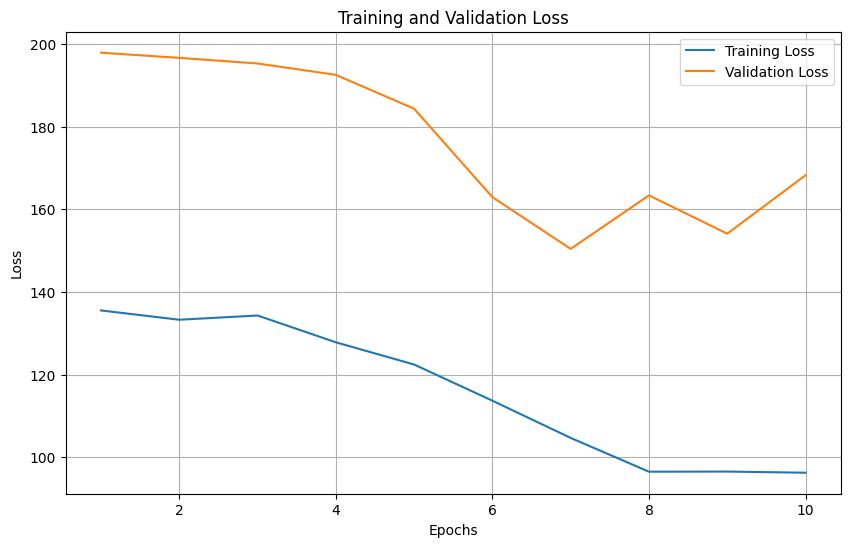

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

**Testing the Model**

1. Importing Required Libraries.

In [10]:
import os
import random
from PIL import Image, ImageDraw
from torchvision.transforms import ToPILImage

2. TestImageDataset, is a custom class of a PyTorch dataset designed to handle test images without annotations.
    - Loads test images from the specified directory.

In [11]:
class TestImageDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.image_paths = sorted([os.path.join(root, fname) for fname in os.listdir(root) if fname.endswith(('.jpg', '.png'))])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, image_path

3. Load the Test Dataset:
    - Select a Random Subset of Test Images (20).

In [12]:

print("Loading test dataset...")
test_dataset = TestImageDataset(
    root='/kaggle/input/coco-2017-dataset/coco2017/test2017',
    transform=transform
)

random.seed(42)
test_indices = random.sample(range(len(test_dataset)), 20)
test_subset = torch.utils.data.Subset(test_dataset, test_indices)

test_loader = DataLoader(test_subset, batch_size=1, shuffle=False)

Loading test dataset...


4. Displaying detection.
    - Draw the predicted bounding boxes and labels on the input image.
    - Filter Low-Confidence Predictions (draw bounding box on predictions above 50 percent confidence score)
    - Add text label of class or category name.

In [13]:
def draw_predictions(image, predictions, category_names, threshold=0.5):
    draw = ImageDraw.Draw(image)
    for box, label, score in zip(predictions['boxes'], predictions['labels'], predictions['scores']):
        if score > threshold:
            box = box.tolist()
            label_text = category_names[label.item()]
            draw.rectangle(box, outline="red", width=2)
            draw.text((box[0], box[1]), f"{label_text} {score:.2f}", fill="yellow")
    return image

def filter_predictions(outputs, threshold=0.5):
    predictions = []
    for output in outputs:
        keep = output['scores'] > threshold
        predictions.append({
            'boxes': output['boxes'][keep],
            'labels': output['labels'][keep],
            'scores': output['scores'][keep],
        })
    return predictions

5. Helper functions to fix data:
    - Reverting the normalization applied during preprocessing so that the image can be visualized correctly.
    - Fixes invalid or inconsistent bounding box coordinates.

In [14]:
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean

os.makedirs("/kaggle/working/test_results", exist_ok=True)

def correct_bounding_box(box):
    x0, y0, x1, y1 = box
    x0, x1 = min(x0, x1), max(x0, x1)  # Ensure x1 >= x0
    y0, y1 = min(y0, y1), max(y0, y1)  # Ensure y1 >= y0
    return [x0, y0, x1, y1]

6. Starting the Testing Process:
   - Removing the batch dimension from the image tensor.
   - Applying softmax to convert raw classification logits into probabilities.
   - Filters predictions based on a confidence threshold greater than 50 percent.
   - Reverting normalization applied during preprocessing to restore the image to its original color range.
   - Converting into PIL image for visualization.
   - Save the output image with bounding boxes.

In [15]:

print("Starting testing...")
model.eval()

with torch.no_grad():
    for i, (image_tensor, image_path) in enumerate(test_loader):
       
        image_tensor = image_tensor.squeeze(0).to(device)
        
        image_tensor = image_tensor.unsqueeze(0)

        outputs = model(image_tensor)
        class_logits, bbox_regressions = outputs

        class_scores = torch.softmax(class_logits, dim=-1)
        top_scores, top_labels = torch.max(class_scores[0], dim=-1)
        filtered_boxes = bbox_regressions[0]

        keep = top_scores > 0.5
        top_scores = top_scores[keep]
        top_labels = top_labels[keep]
        filtered_boxes = filtered_boxes[keep]

        denormalized_image = denormalize(image_tensor.squeeze(0).cpu(), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).clamp(0, 1)
        pil_image = transforms.ToPILImage()(denormalized_image)

        draw = ImageDraw.Draw(pil_image)
        for box, label, score in zip(filtered_boxes, top_labels, top_scores):
            box = correct_bounding_box(box.cpu().tolist())  # Correct invalid bounding boxes
            label_text = COCO_INSTANCE_CATEGORY_NAMES[label.item()]
            score_text = f"{score.item() * 100:.1f}%"
            draw.rectangle(box, outline="red", width=2)
            draw.text((box[0], box[1]), f"{label_text}: {score_text}", fill="yellow")

        output_path = f"/kaggle/working/test_results/test_image_{i + 1}.jpg"
        pil_image.save(output_path)

        print(f"Processed and saved: {output_path}")

Starting testing...
Processed and saved: /kaggle/working/test_results/test_image_1.jpg
Processed and saved: /kaggle/working/test_results/test_image_2.jpg
Processed and saved: /kaggle/working/test_results/test_image_3.jpg
Processed and saved: /kaggle/working/test_results/test_image_4.jpg
Processed and saved: /kaggle/working/test_results/test_image_5.jpg
Processed and saved: /kaggle/working/test_results/test_image_6.jpg
Processed and saved: /kaggle/working/test_results/test_image_7.jpg
Processed and saved: /kaggle/working/test_results/test_image_8.jpg
Processed and saved: /kaggle/working/test_results/test_image_9.jpg
Processed and saved: /kaggle/working/test_results/test_image_10.jpg
Processed and saved: /kaggle/working/test_results/test_image_11.jpg
Processed and saved: /kaggle/working/test_results/test_image_12.jpg
Processed and saved: /kaggle/working/test_results/test_image_13.jpg
Processed and saved: /kaggle/working/test_results/test_image_14.jpg
Processed and saved: /kaggle/working/